## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

## 1. Import libraries

In [ ]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats

from glob import glob
from itertools import chain

from keras.applications.vgg16 import VGG16
# from keras.applications.resnet import ResNet50 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.metrics import Precision, Recall, TruePositives, TrueNegatives
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from skimage import filters
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc, auc, RocCurveDisplay, PrecisionRecallDisplay
from typing import Tuple

%matplotlib inline
sns.set_style('white')
plt.rc("axes.spines", top=False, right=False)

## 2. Data loading

In [2]:
# Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

# Read full image filepaths into a dataframe for easier manipulation
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
72032,00017744_000.png,Atelectasis,0,17744,68,M,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00017744_000.png
49061,00012433_000.png,No Finding,0,12433,27,M,PA,2992,2991,0.143,0.143,NaN,/data/images_006/images/00012433_000.png
7612,00001992_016.png,No Finding,16,1992,17,F,AP,2500,2048,0.168,0.168,NaN,/data/images_002/images/00001992_016.png


In [3]:
print(f'Number of entries: {all_xray_df.shape[0]:,.0f}')
print(f'Number of unique images: {all_xray_df["Image Index"].nunique():,.0f}')
print(f'Number of unique patients: {all_xray_df["Patient ID"].nunique():,.0f}')
print(f'Number of unique labels: {all_xray_df["Finding Labels"].nunique():,.0f}')
print(f'Number of unique genders: {all_xray_df["Patient Gender"].nunique():,.0f}')
print(f'Number of unique view positions: {all_xray_df["View Position"].nunique():,.0f}')

Number of entries: 112,120
Number of unique images: 112,120
Number of unique patients: 30,805
Number of unique labels: 836
Number of unique genders: 2
Number of unique view positions: 2


## 3. Data preprocessing

### 3.1. Data cleaning

In [4]:
outliers_age = all_xray_df[all_xray_df['Patient Age'] > 100]
print('Number of outliers with age > 100 years old:', outliers_age.shape[0])
outliers_age

Number of outliers with age > 100 years old: 16


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139,NaN,/data/images_003/images/00005567_000.png
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,NaN,/data/images_006/images/00011973_002.png
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143,NaN,/data/images_006/images/00012238_010.png
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143,NaN,/data/images_007/images/00013950_000.png
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143,NaN,/data/images_007/images/00014520_026.png
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143,NaN,/data/images_007/images/00015558_000.png
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143,NaN,/data/images_008/images/00018366_044.png
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143,NaN,/data/images_009/images/00019346_000.png
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139,NaN,/data/images_009/images/00020900_002.png
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139,NaN,/data/images_010/images/00021047_002.png


In [5]:
all_xray_df = all_xray_df.drop(columns='Unnamed: 11')
# Drop outliers with ages higher than 100 years old to avoid biases
# Reason: There are just 16 entries out of 112,120
all_xray_df = all_xray_df.loc[all_xray_df['Patient Age'] <= 100].copy()

### 3.2. Label pre-processing

In [6]:
## Add binary indicators for diseases 
entry_findings = all_xray_df['Finding Labels'].map(lambda x: x.split('|'))
all_diseases = set(chain.from_iterable(entry_findings.tolist()))

diseases = pd.DataFrame(index=all_xray_df.index)
for disease in all_diseases:
    diseases[disease] = all_xray_df['Finding Labels'].map(lambda x: disease in x)

diseases = diseases.astype(np.int64)
all_xray_df = pd.concat([all_xray_df, diseases], axis=1)
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Pleural_Thickening,Emphysema,Hernia,Consolidation,Cardiomegaly,Pneumonia,Mass,Edema,Atelectasis
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,1,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,1,0,0,1,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,1,1,0,0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0


In [7]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = np.where(all_xray_df['Pneumonia'], 'pneumonia', 'no_pneumonia')
all_xray_df['pneumonia_class'].value_counts()

no_pneumonia    110674
pneumonia         1430
Name: pneumonia_class, dtype: int64

### 3.3. Data splitting

In [8]:
def undersample(train_df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    ''' Randomly undersample a DataFrame according to the target column
    
    The sampling strategy is defined to 0.5 so that the samples with the
    target class represent half of the dataset used for training.
    
    Alternatives: 
    https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
    '''
    ratio_pneumonia = 0.5  # 50% of the images in the training set with Pneumonia
    neg_ratio = int(1 / ratio_pneumonia - 1)
    
    pos_indexes = train_df.loc[train_df[target_col] == 'pneumonia'].index.tolist()
    neg_indexes = train_df.loc[train_df[target_col] == 'no_pneumonia'].index.tolist()

    neg_samples = random.sample(neg_indexes, neg_ratio * len(pos_indexes))
    return train_df.loc[pos_indexes + neg_samples].copy()
    
    
def create_splits(
    df: pd.DataFrame, 
    test_size: float, 
    stratify: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame]:
    ''' Splits the data into training and validation sets.
    
    It applies an undersampling strategy for the training set.
    The validation set represents the prevalence of the target class
    on the target population.
    '''
    
    train_data, val_data = train_test_split(
        df, 
        test_size=test_size,
        shuffle=True,
        stratify=stratify, 
        random_state=0,
    )
    
    train_data = undersample(train_data, 'pneumonia_class')
    
    return train_data, val_data

In [9]:
train_df, val_df = create_splits(df=all_xray_df, test_size=0.2, stratify=all_xray_df.pneumonia_class)

print('Class distribution in the training set:')
print(train_df.pneumonia_class.value_counts(normalize=False))
print(train_df.pneumonia_class.value_counts(normalize=True))

print('\nClass distribution in the validation set:')
print(val_df.pneumonia_class.value_counts(normalize=False))
print(val_df.pneumonia_class.value_counts(normalize=True))

Class distribution in the training set:
no_pneumonia    1144
pneumonia       1144
Name: pneumonia_class, dtype: int64
no_pneumonia    0.5
pneumonia       0.5
Name: pneumonia_class, dtype: float64

Class distribution in the validation set:
no_pneumonia    22135
pneumonia         286
Name: pneumonia_class, dtype: int64
no_pneumonia    0.987244
pneumonia       0.012756
Name: pneumonia_class, dtype: float64


## 4. Model training

### 4.1. Data augmentation

In [19]:
def img_size_vgg16():
    '''Return the img size used as input by VGG16'''
    return (224, 224)

def my_image_augmentation_train_set():    
    return ImageDataGenerator(rescale=1./255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 15, 
                              shear_range = 0.1,
                              zoom_range = 0.1,
                             )

def image_augmentation_val_set():
    return ImageDataGenerator(rescale=1./255.0)


def make_train_gen(df):
    '''Create image generators for the training data'''
    generator = my_image_augmentation_train_set()
    return generator.flow_from_dataframe(dataframe=df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = img_size_vgg16(),
                                         shuffle = True,
                                         batch_size = 32
                                         )
    return train_gen


def make_val_gen(df):
    '''Create image generators for the validation data'''
    generator = image_augmentation_val_set()
    val_gen = generator.flow_from_dataframe(dataframe=df, 
                                            directory=None, 
                                            x_col = 'path',
                                            y_col = 'pneumonia_class',
                                            class_mode = 'binary',
                                            target_size = img_size_vgg16(), 
                                            batch_size = 128) 
    return val_gen

In [22]:
def plot_sample(x, y):
    '''Look at some examples of the data'''
    fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
    for (c_x, c_y, c_ax) in zip(x, y, m_axs.flatten()):
        c_ax.imshow(c_x[:,:,0], cmap = 'bone')
        if c_y == 1: 
            c_ax.set_title('Pneumonia')
        else:
            c_ax.set_title('No Pneumonia')
        c_ax.axis('off')

Found 22421 validated image filenames belonging to 2 classes.


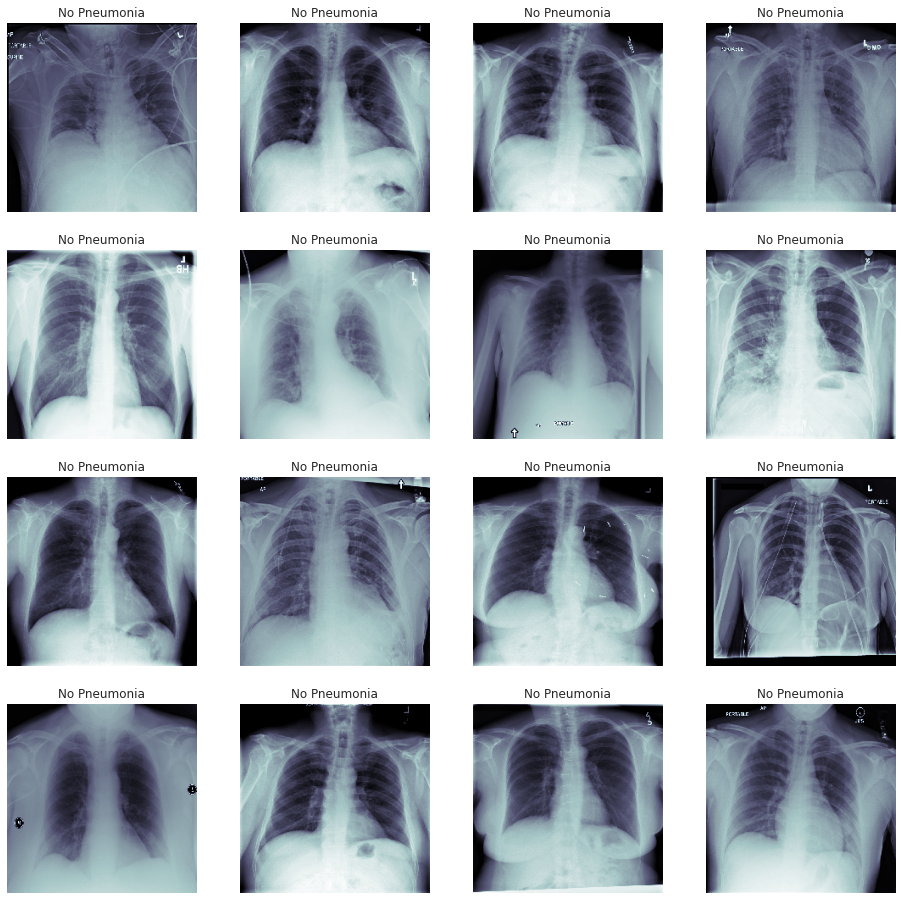

In [21]:
## Pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_df)
val_x, val_y = val_gen.next()
plot_sample(val_x, val_y)

Found 2288 validated image filenames belonging to 2 classes.


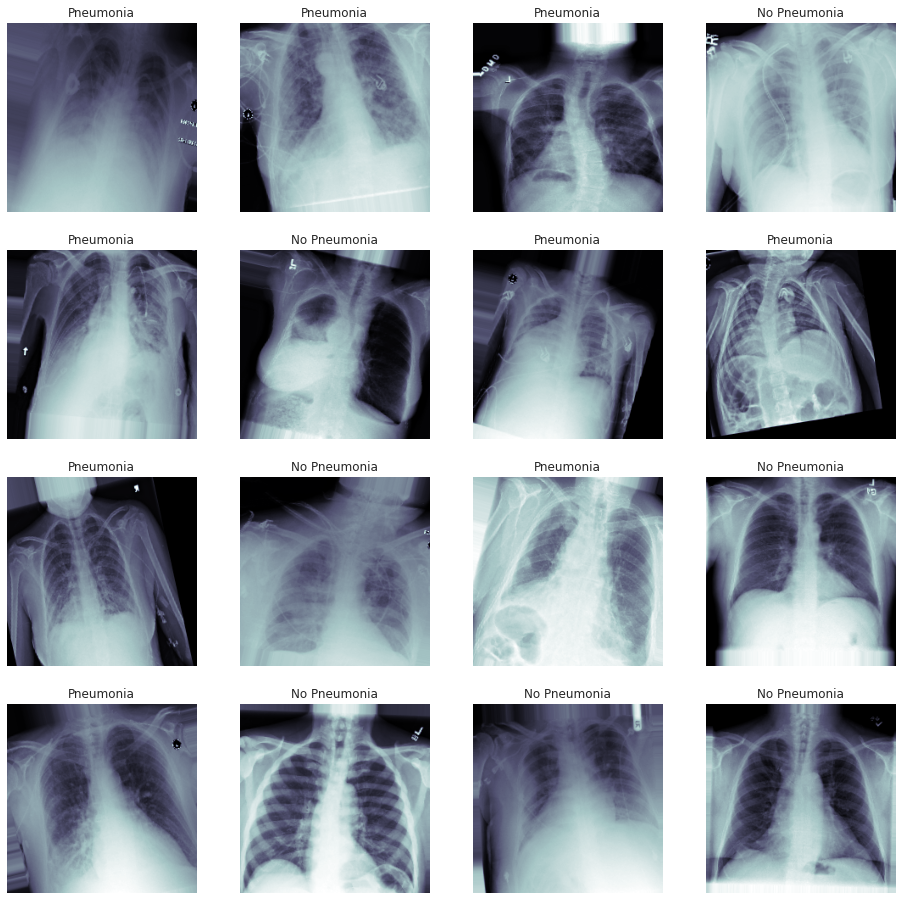

In [18]:
train_gen = make_train_gen(train_df)
t_x, t_y = next(train_gen)
plot_sample(t_x, t_y)

### 4.2. Model building

In [32]:
def load_pretrained_vgg16_model():
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')  # Last Conv layer
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
    
    # Freeze all but the last convolutional layer
    for layer in vgg_model.layers[:17]:
        layer.trainable = False

    print('Layers:')
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)

    return vgg_model

In [37]:
def build_my_model():
    
    my_model = Sequential()    
    vgg_model = load_pretrained_vgg16_model()
    my_model.add(vgg_model)

    my_model.add(Flatten())    
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.25))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.25))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy', Precision(), Recall(), TruePositives(), TrueNegatives()]    
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model

In [38]:
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only=True)

early = EarlyStopping(monitor='loss', 
                      mode='min', 
                      patience=10)

callbacks_list = [checkpoint, early]

In [39]:
my_model = build_my_model()
my_model.summary()

Layers:
input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
___________________________

### 4.3. Train model

In [40]:
history = my_model.fit_generator(train_gen, 
                                  validation_data=(val_x, val_y), 
                                  epochs=10,
                                  callbacks=callbacks_list)

Epoch 1/1
35/72 [=============>................] - ETA: 19:00 - loss: 0.7226 - binary_accuracy: 0.5245 - precision_1: 0.5255 - recall_1: 0.5208 - true_positives_1: 288.0000 - true_negatives_1: 291.0000

KeyboardInterrupt: 

In [ ]:
def plot_history(history):
    N = len(history.history["loss"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.plot(np.arange(0, N), history.history["recall"], label="train_recall")
    plt.plot(np.arange(0, N), history.history["val_recall"], label="val_recall")    
    
    plt.title("Training Loss, Accuracy, and Recall")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    
plot_history(history)

### 4.4. Evaluate model performance

In [ ]:
## Note that detecting pneumonia is hard even for trained expert radiologists
my_model.load_weights(weight_path)
pred_Y = my_model.predict(val_x, batch_size=32, verbose=True)

In [ ]:
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    plt.show()


def plot_precision_recall_curve(t_y, p_y):
    PrecisionRecallDisplay.from_predictions(t_y, p_y)
    plt.show()

In [ ]:
## plot figures

# Todo

### 4.5. Fine tune classification threshold

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)